In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
from itertools import combinations

In [236]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")

columns_not_needed_20 = ['user_id', 'account_age_in_days', 'bot', 'created_at', 'name', 'lang', 
                        'avg_tweets_per_actual_day', 'avt_favorite_count', 'total_replies',
                        'tweet_num_replies_ratio', 'max_number_of_tweet_in_a_day', 'total_likes',
                        'total_retweet_count', 'tweet_num_likes_ratio', 'number_of_tweets', 
                        'avg_text_length', 'statuses_count', 'day_with_most_tweets', 'avg_mentions',
                        'entropy_for_day', 'entropy_for_hour', 'avt_reply_count', 'account_discussion_creation_ratio', 
                        'account_average_tweets_per_day', 'avg_special_char_in_text']
columns_not_needed_30 = ['user_id', 'account_age_in_days', 'bot', 'created_at', 'name', 'lang', 
                        'avg_tweets_per_actual_day', 'avt_favorite_count', 'total_replies',
                        'tweet_num_replies_ratio', 'max_number_of_tweet_in_a_day', 'total_likes',
                        'total_retweet_count', 'tweet_num_likes_ratio', 'number_of_tweets', 
                        'avg_text_length', 'statuses_count', 'day_with_most_tweets', 'avg_mentions',
                        'entropy_for_day', 'entropy_per_hour', 'avt_reply_count', 'account_discussion_creation_ratio']
columns_not_needed_50 = ['user_id', 'account_age_in_days', 'bot', 'created_at', 'name', 'lang', 
                        'avg_tweets_per_actual_day', 'avt_favorite_count', 'total_replies',
                        'tweet_num_replies_ratio', 'max_number_of_tweet_in_a_day', 'total_likes',
                        'total_retweet_count', 'tweet_num_likes_ratio', 'number_of_tweets', 
                        'avg_text_length', 'statuses_count', 'day_with_most_tweets', 'avg_mentions',
                        'entropy_for_day', 'entropy_for_hour']
columns_not_needed_70 = ['user_id', 'account_age_in_days', 'bot', 'created_at', 'name', 'lang', 
                        'avg_tweets_per_actual_day', 'avt_favorite_count', 'total_replies',
                        'tweet_num_replies_ratio', 'max_number_of_tweet_in_a_day', 'total_likes',
                        'total_retweet_count', 'tweet_num_likes_ratio', 'number_of_tweets', 
                        'avg_text_length', 'statuses_count', 'day_with_most_tweets']

users_df_20 = users_df[users_df.columns.difference(columns_not_needed_20)]
users_df_30 = users_df[users_df.columns.difference(columns_not_needed_30)]
users_df_50 = users_df[users_df.columns.difference(columns_not_needed_50)]
users_df_70 = users_df[users_df.columns.difference(columns_not_needed_70)]

users_df_20.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   avg_hashtags        11109 non-null  float64
 1   entropy_for_minute  11109 non-null  float64
dtypes: float64(2)
memory usage: 173.7 KB


# KMeans

In [237]:
all_possible_combinations = list(combinations(users_df_70.columns, 2))
combination = ['entropy_for_minute', 'avg_hashtags']
subset_df = users_df_20
scaler = StandardScaler()
scaler.fit(subset_df.values)
transform_result = scaler.fit_transform(subset_df.values)

In [238]:
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=150)
kmeans.fit(transform_result)

KMeans(max_iter=150, n_clusters=6)

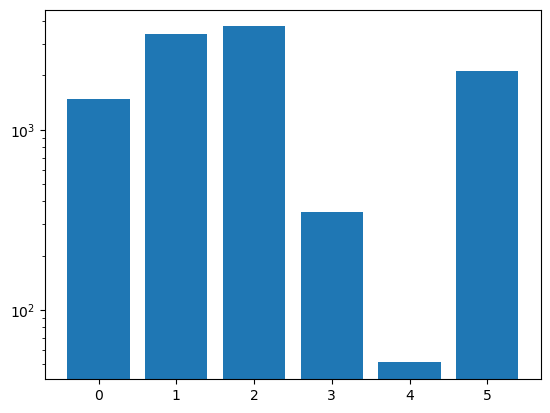

In [239]:
clusters_id, clusters_sizes = np.unique(kmeans.labels_, return_counts=True)

plt.bar(x=clusters_id, height=clusters_sizes, log=True)
plt.show()

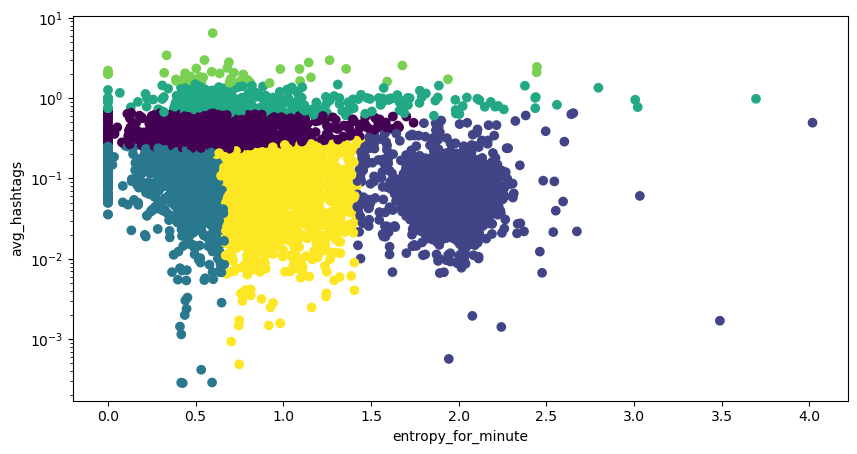

In [240]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(data=users_df, x=combination[0], y=combination[1],c=kmeans.labels_)
ax.set_yscale('log')
ax.set_xlabel(combination[0])
ax.set_ylabel(combination[1])
fig.show()

/var/folders/83/4hrtk21x7lq8yn57wngsh6zm0000gn/T/ipykernel_921/3186447602.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


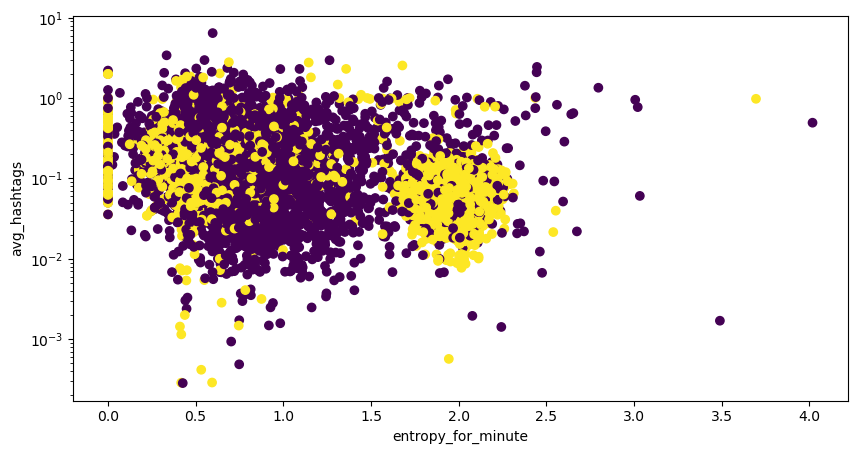

In [241]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.scatter(data=users_df, x=combination[0], y=combination[1],c='bot')
ax2.set_yscale('log')
ax2.set_xlabel(combination[0])
ax2.set_ylabel(combination[1])
fig.show()

In [242]:
clustering_utils.print_clustering_metrics(kmeans, transform_result)

SSE 2854.232306814275
Silhouette 0.4980445713160215
Separation 0.741443721489151



## Running multiple K-means and plotting SSE

Trying to plot the relation between K centroids and SSE. The main problem is: what indica

<AxesSubplot:xlabel='K'>

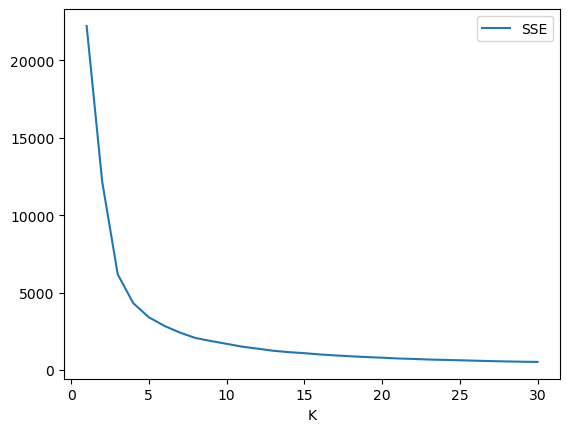

In [243]:
results = []
for k in range(1,31):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=150)
    kmeans.fit(transform_result)
    SSE = kmeans.inertia_
    results.append([k, SSE])
    
results_df = pd.DataFrame(results, columns=["K", "SSE"])
results_df.plot(x="K", y="SSE")